In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
import json
import os
from tqdm import tqdm
import numpy as np

from zipfile import ZipFile
file_name = "/content/sample_data/TestDataSet.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


## Task 1

In [4]:
# Load a pretrained ResNet-34 model (ImageNet-1K weights)
model = torchvision.models.resnet34(weights='IMAGENET1K_V1').cuda().eval()

# Load ImageNet label indices from JSON
with open("./TestDataSet/labels_list.json", "r") as f:
    label_map = json.load(f)
imagenet_indices = [int(entry.split(":")[0]) for entry in label_map]

# Define normalization parameters for preprocessing
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Define a transform: convert image to tensor and normalize it
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Load dataset with preprocessing applied
dataset = torchvision.datasets.ImageFolder(root="./TestDataSet", transform=transform)

# Create a DataLoader for batching and efficiency
dataloader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)


# Evaluate the model on the dataset
top1_hits = 0
top5_hits = 0
num_samples = 0

with torch.no_grad():
    for imgs, labels in tqdm(dataloader):
        imgs = imgs.cuda()
        labels = labels.cuda()

        # Forward pass through the model
        logits = model(imgs)  # Shape: [batch_size, 1000]

        # Restrict to the 100 target class indices
        logits_filtered = logits[:, imagenet_indices]

        # Get top-5 predictions
        _, top5_preds = logits_filtered.topk(5, dim=1)  # Shape: [batch_size, 5]
        top1_preds = top5_preds[:, 0]  # Shape: [batch_size]

        # Calculate top-1 accuracy
        top1_hits += (top1_preds == labels).sum().item()

        # Calculate top-5 accuracy
        top5_hits += sum([labels[i] in top5_preds[i] for i in range(len(labels))])

        num_samples += labels.size(0)

print()

# Compute final accuracies
top1_accuracy = top1_hits / num_samples
top5_accuracy = top5_hits / num_samples

print(f"Top-1 Accuracy: {top1_accuracy * 100:.2f}%")
print(f"Top-5 Accuracy: {top5_accuracy * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.19it/s]


Top-1 Accuracy: 89.60%
Top-5 Accuracy: 99.40%


# Task 2

Generating FGSM adversarial examples...


100%|██████████| 500/500 [00:20<00:00, 24.95it/s]


Adversarial image generation complete.
Displaying a few misclassified adversarial examples...


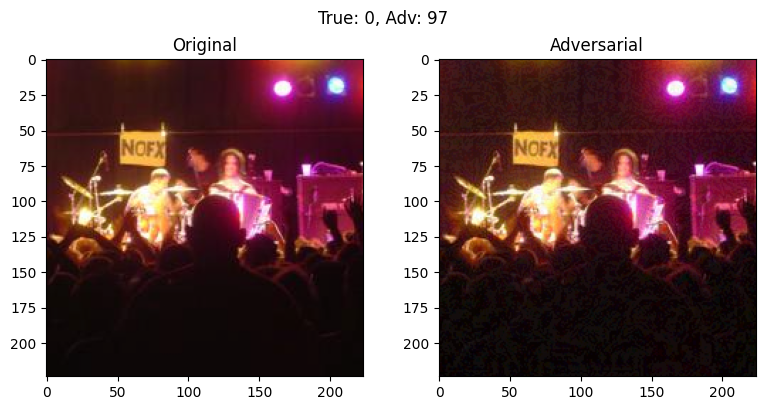

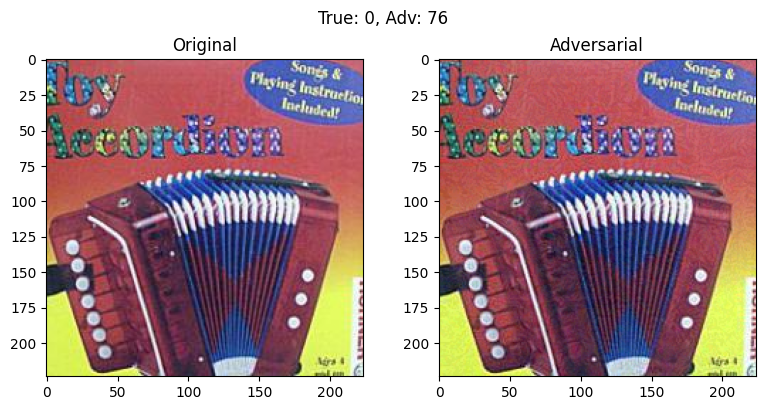

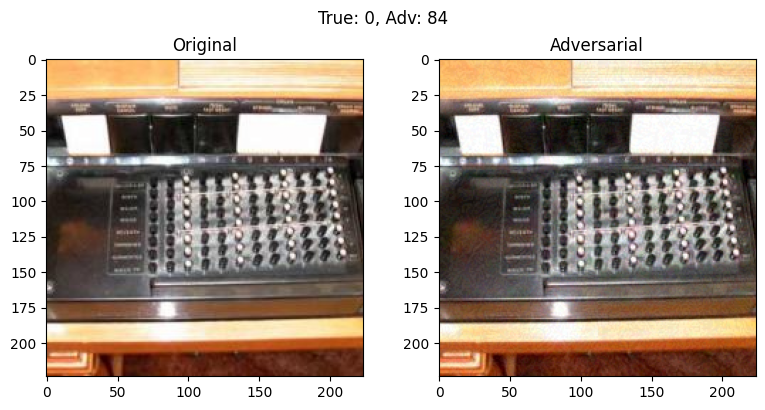

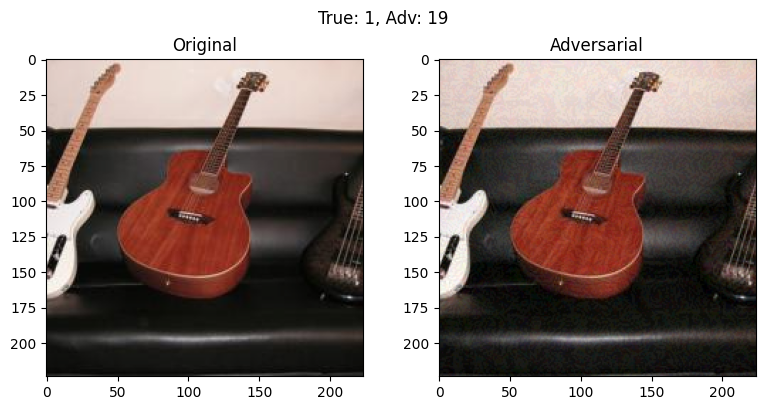

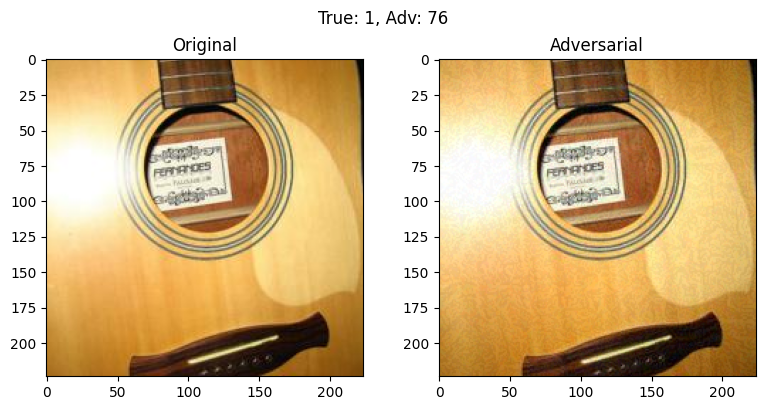

Evaluating model on adversarial set...

FGSM Evaluation (ε = 0.02)
Top-1 Accuracy: 8.80%
Top-5 Accuracy: 39.80%


In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import json
import os
from tqdm import tqdm
from torchvision.utils import save_image
from PIL import Image
from torch.utils.data import DataLoader

# Load pretrained ResNet-34 model
model = torchvision.models.resnet34(weights='IMAGENET1K_V1').cuda().eval()

# Load ImageNet class indices from JSON
with open("./TestDataSet/labels_list.json", "r") as f:
    labels = json.load(f)
imagenet_indices = [int(label.split(":")[0]) for label in labels]

# Define normalization and unnormalization transforms
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
normalize = transforms.Normalize(mean=mean, std=std)
unnormalize = transforms.Normalize(mean=-mean / std, std=1 / std)

# Tensor conversion
to_tensor = transforms.ToTensor()

# FGSM configuration
epsilon = 0.02

# Load dataset (no transforms yet)
dataset = torchvision.datasets.ImageFolder(root="./TestDataSet", transform=lambda x: x)

# Directory to save adversarial images
save_dir = "Adversarial_Test_Set_1"
os.makedirs(save_dir, exist_ok=True)

# Store image tensors and labels
orig_images, adv_images = [], []
true_labels, adv_labels = [], []

print("Generating FGSM adversarial examples...")

# FGSM generation loop
for i, (img_pil, label) in enumerate(tqdm(dataset)):
    img_tensor = to_tensor(img_pil).unsqueeze(0).cuda().requires_grad_(True)
    img_norm = normalize(img_tensor)

    output = model(img_norm)
    output_masked = output[:, imagenet_indices]
    loss = torch.nn.functional.cross_entropy(output_masked, torch.tensor([label]).cuda())

    model.zero_grad()
    loss.backward()

    perturbation = epsilon * img_tensor.grad.sign()
    adv_tensor = torch.clamp(img_tensor + perturbation, 0, 1)
    adv_norm = normalize(adv_tensor)

    # Save adversarial image
    save_image(adv_tensor.squeeze().cpu(), os.path.join(save_dir, f"adv_{i:04d}.png"))

    # Record predictions
    with torch.no_grad():
        pred = model(adv_norm)
        pred_masked = pred[:, imagenet_indices]
        pred_label = pred_masked.argmax(dim=1).item()

    orig_images.append(img_norm.cpu())
    adv_images.append(adv_norm.cpu())
    true_labels.append(label)
    adv_labels.append(pred_label)

print("Adversarial image generation complete.")

# Stack tensors for batch processing
orig_images = torch.cat(orig_images)
adv_images = torch.cat(adv_images)
true_labels = torch.tensor(true_labels)
adv_labels = torch.tensor(adv_labels)

# Visualize a few misclassifications
print("Displaying a few misclassified adversarial examples...")
misclassified = (adv_labels != true_labels).nonzero(as_tuple=True)[0]
for i in misclassified[:5]:
    orig = unnormalize(orig_images[i]).permute(1, 2, 0).detach().numpy()
    adv = unnormalize(adv_images[i]).permute(1, 2, 0).detach().numpy()

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(np.clip(orig, 0, 1))
    axs[0].set_title("Original")
    axs[1].imshow(np.clip(adv, 0, 1))
    axs[1].set_title("Adversarial")
    plt.suptitle(f"True: {true_labels[i].item()}, Adv: {adv_labels[i].item()}")
    plt.tight_layout()
    plt.show()

# Evaluate accuracy on adversarial examples
print("Evaluating model on adversarial set...")
top1_correct = top5_correct = total = 0

with torch.no_grad():
    for i in range(0, len(adv_images), 64):
        batch = adv_images[i:i + 64].cuda()
        labels_batch = true_labels[i:i + 64].cuda()

        outputs = model(batch)
        masked_outputs = outputs[:, imagenet_indices]
        _, top5 = masked_outputs.topk(5, dim=1)
        top1 = top5[:, 0]

        top1_correct += (top1 == labels_batch).sum().item()
        top5_correct += sum(labels_batch[j] in top5[j] for j in range(len(labels_batch)))
        total += labels_batch.size(0)

top1_acc = top1_correct / total
top5_acc = top5_correct / total

print(f"\nFGSM Evaluation (ε = {epsilon})")
print(f"Top-1 Accuracy: {top1_acc * 100:.2f}%")
print(f"Top-5 Accuracy: {top5_acc * 100:.2f}%")


# Task 3

Running PGD attack on dataset...


100%|██████████| 500/500 [01:23<00:00,  5.99it/s]


PGD adversarial images generated.
Visualizing misclassified PGD samples:


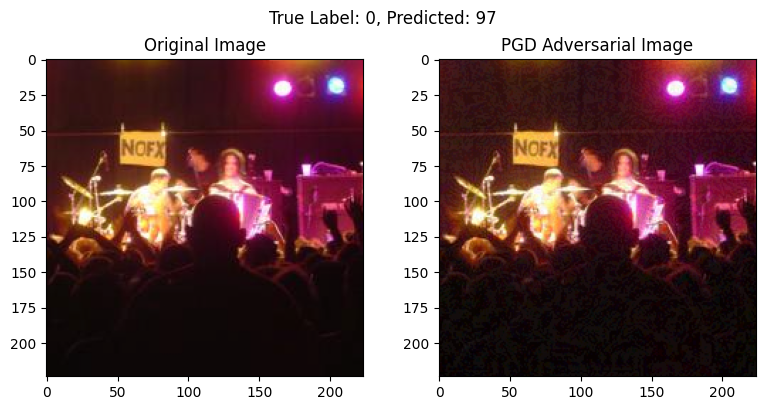

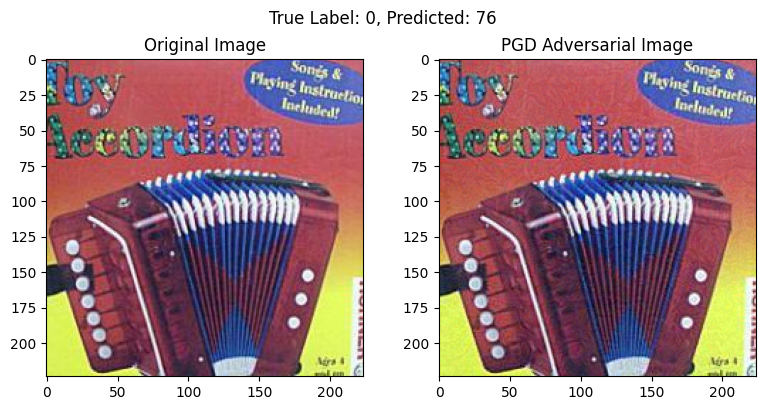

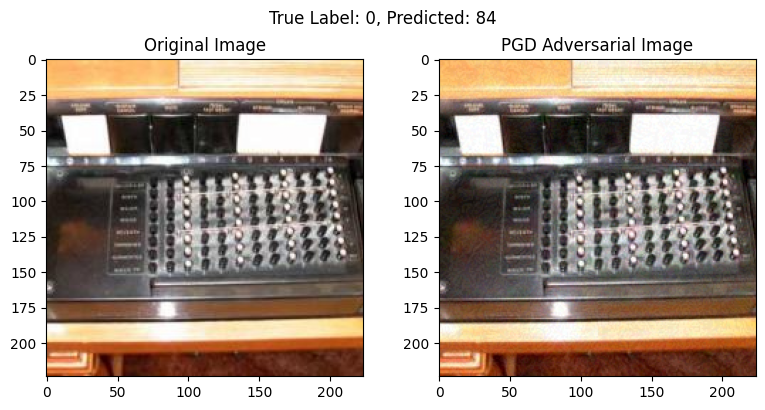

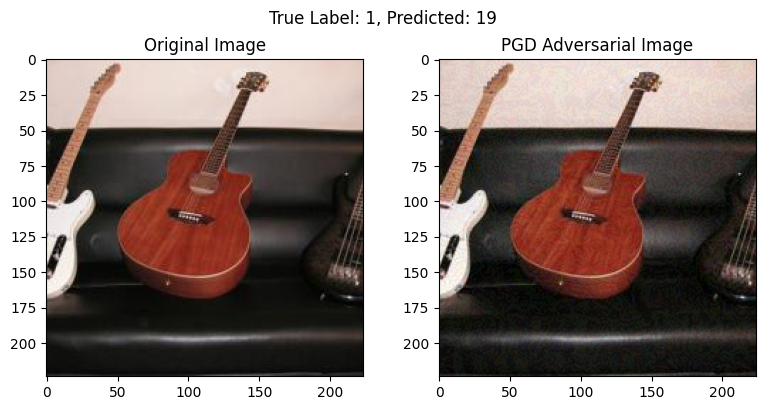

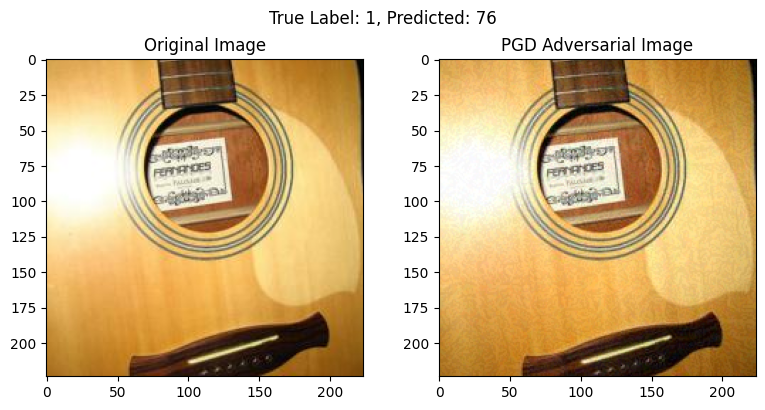

Evaluating accuracy on the PGD adversarial test set...
PGD Evaluation on Adversarial Set 2 (ε = 0.02)
Top-1 Accuracy: 8.80%
Top-5 Accuracy: 39.80%


In [7]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import json
import os
from tqdm import tqdm
from torchvision.utils import save_image
from PIL import Image
from torch.utils.data import DataLoader

# Load the pre-trained ResNet34 model
model = torchvision.models.resnet34(weights='IMAGENET1K_V1').cuda().eval()

# Load label indices from JSON file
with open("./TestDataSet/labels_list.json", "r") as file:
    label_data = json.load(file)
imagenet_class_indices = [int(entry.split(":")[0]) for entry in label_data]

# Define normalization and un-normalization transformations
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
normalize_transform = transforms.Normalize(mean=mean, std=std)
unnormalize_transform = transforms.Normalize(mean=-mean / std, std=1 / std)

tensor_transform = transforms.ToTensor()
epsilon = 0.02  # Maximum perturbation
alpha = 0.005  # Step size for PGD attack
num_steps = 10  # Number of PGD iterations

# Set up dataset and data directory
dataset_dir = "./TestDataSet"
image_dataset = torchvision.datasets.ImageFolder(root=dataset_dir, transform=lambda x: x)

# Create directory to save adversarial images
adv_image_dir = "Adversarial_Test_Set_2"
os.makedirs(adv_image_dir, exist_ok=True)

# Initialize lists to store adversarial and original images and their labels
adversarial_images = []
original_images = []
true_labels = []
predicted_labels = []

print("Running PGD attack on dataset...")

# Generate adversarial examples using PGD attack
for idx, (image_pil, label) in enumerate(tqdm(image_dataset)):
    image_tensor = tensor_transform(image_pil).unsqueeze(0).cuda()
    original_image = image_tensor.clone()  # Keep a copy of the original image
    image_tensor.requires_grad = True  # Enable gradient computation

    perturbed_image = image_tensor.clone()  # Start with the original image as the perturbed one
    for _ in range(num_steps):
        normalized_image = normalize_transform(perturbed_image)
        output = model(normalized_image)
        loss = torch.nn.functional.cross_entropy(output[:, imagenet_class_indices], torch.tensor([label]).cuda())

        model.zero_grad()
        loss.backward()  # Compute gradients

        gradient = image_tensor.grad
        perturbed_image = perturbed_image + alpha * gradient.sign()  # Apply gradient sign update
        delta = torch.clamp(perturbed_image - original_image, min=-epsilon, max=epsilon)  # Limit perturbation
        perturbed_image = torch.clamp(original_image + delta, 0, 1).detach().requires_grad_(True)  # Ensure it's within valid bounds

    # Save the adversarial image
    save_path = os.path.join(adv_image_dir, f"adv_{idx:04d}.png")
    save_image(perturbed_image.detach().cpu().squeeze(), save_path)

    # Evaluate the adversarial image
    normalized_adv_image = normalize_transform(perturbed_image.detach())
    with torch.no_grad():
        prediction = model(normalized_adv_image)
        masked_prediction = prediction[:, imagenet_class_indices]
        top1_prediction = masked_prediction.argmax(dim=1)

        adversarial_images.append(normalized_adv_image.cpu())
        original_images.append(normalize_transform(original_image).cpu())
        true_labels.append(label)
        predicted_labels.append(top1_prediction.item())

print("PGD adversarial images generated.")

# Stack images and labels for evaluation
adversarial_images = torch.cat(adversarial_images)
original_images = torch.cat(original_images)
true_labels = torch.tensor(true_labels)
predicted_labels = torch.tensor(predicted_labels)

# Visualize some misclassified adversarial samples
print("Visualizing misclassified PGD samples:")
misclassified_indices = (predicted_labels != true_labels).nonzero(as_tuple=True)[0]
for i in misclassified_indices[:5]:
    original_img = unnormalize_transform(original_images[i]).permute(1, 2, 0).numpy()
    adversarial_img = unnormalize_transform(adversarial_images[i]).permute(1, 2, 0).numpy()

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(np.clip(original_img, 0, 1))
    axs[0].set_title("Original Image")
    axs[1].imshow(np.clip(adversarial_img, 0, 1))
    axs[1].set_title("PGD Adversarial Image")
    plt.suptitle(f"True Label: {true_labels[i].item()}, Predicted: {predicted_labels[i].item()}")
    plt.tight_layout()
    plt.show()

# Evaluate the accuracy on the PGD adversarial test set
print("Evaluating accuracy on the PGD adversarial test set...")

top1_correct, top5_correct = 0, 0
total_samples = 0

with torch.no_grad():
    for i in range(0, len(adversarial_images), 64):
        batch = adversarial_images[i:i+64].cuda()
        targets = true_labels[i:i+64].cuda()
        outputs = model(batch)
        masked_outputs = outputs[:, imagenet_class_indices]

        _, top5_predictions = masked_outputs.topk(5, dim=1)
        top1_predictions = top5_predictions[:, 0]

        top1_correct += (top1_predictions == targets).sum().item()
        top5_correct += sum([targets[j] in top5_predictions[j] for j in range(len(targets))])
        total_samples += targets.size(0)

adversarial_top1_accuracy = top1_correct / total_samples
adversarial_top5_accuracy = top5_correct / total_samples

print(f"PGD Evaluation on Adversarial Set 2 (ε = {epsilon})")
print(f"Top-1 Accuracy: {adversarial_top1_accuracy * 100:.2f}%")
print(f"Top-5 Accuracy: {adversarial_top5_accuracy * 100:.2f}%")


# Task 4

Running PGD attack with 32x32 patches...


100%|██████████| 500/500 [11:58<00:00,  1.44s/it]


Adversarial images saved to Adversarial_Test_Set_3.
Visualizing adversarial examples (32x32 patch attack):


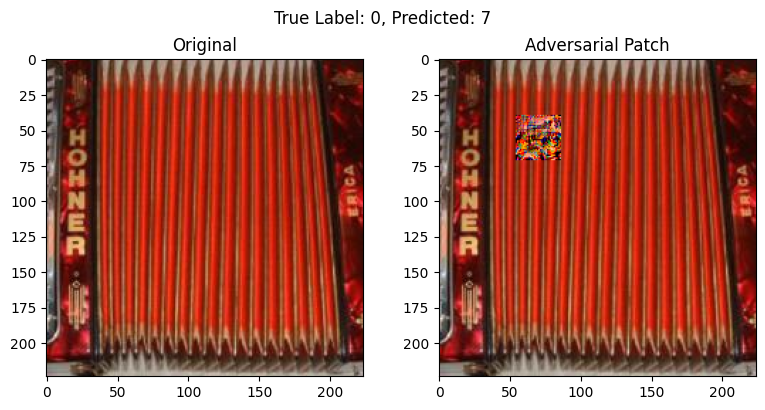

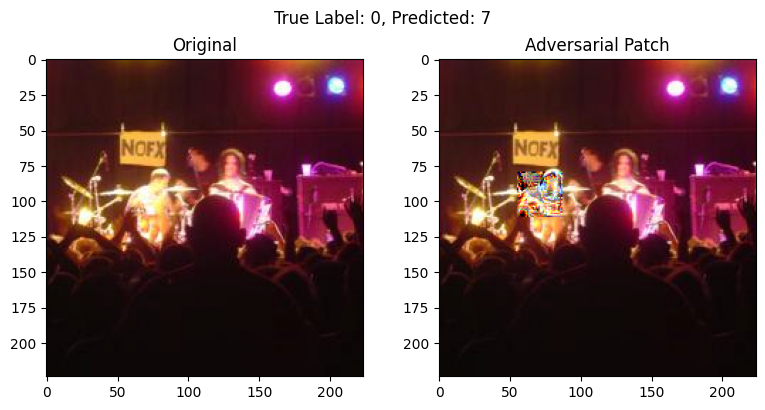

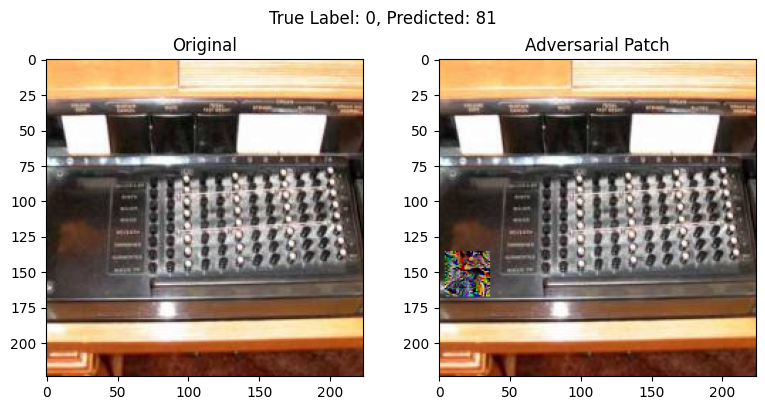

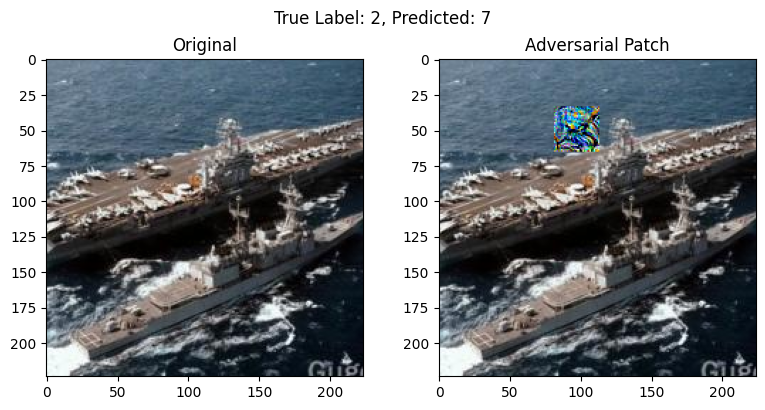

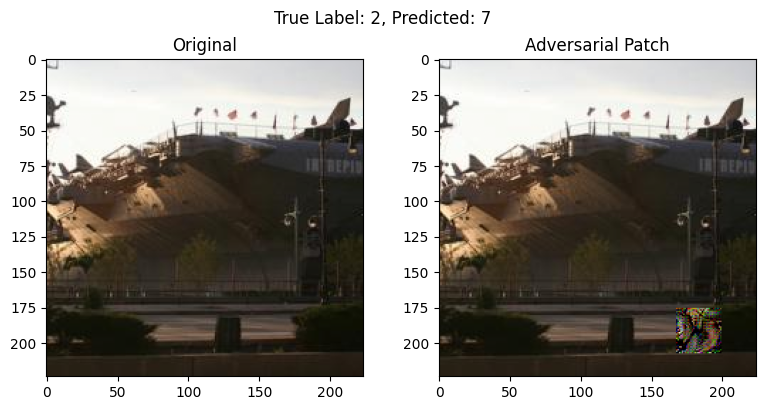

Evaluating PGD attack accuracy...
Adversarial Test Set (PGD Attack, ε = 0.5)
Top-1 Accuracy: 44.40%
Top-5 Accuracy: 87.80%


In [8]:
import torch
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
import json
import os
from tqdm import tqdm
from torchvision.utils import save_image
import random

# Load pretrained ResNet-34 model
model = torchvision.models.resnet34(weights='IMAGENET1K_V1').cuda().eval()

# Load label indices
with open("./TestDataSet/labels_list.json", "r") as f:
    label_data = json.load(f)
imagenet_indices = [int(entry.split(":")[0]) for entry in label_data]

# Normalization parameters for ImageNet
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
normalize_transform = T.Normalize(mean=mean, std=std)
unnormalize_transform = T.Normalize(mean=-mean / std, std=1 / std)

to_tensor_transform = T.ToTensor()

# Target class for the attack (Amphibian)
target_class_id = 7

# PGD attack configuration
epsilon_value = 0.5        # Maximum perturbation per pixel (L∞ norm)
alpha_value = 0.01         # Step size per PGD iteration
num_iterations = 100       # Number of PGD steps
momentum_factor = 0.9      # Gradient momentum coefficient
patch_dim = 32             # Side length of the attack patch

# Dataset and directory setup
dataset_root = "./TestDataSet"
dataset = torchvision.datasets.ImageFolder(root=dataset_root, transform=lambda x: x)

output_dir = "Adversarial_Test_Set_3"
os.makedirs(output_dir, exist_ok=True)

adv_images = []
original_images = []
true_class_labels = []
adv_class_labels = []

print("Running PGD attack with 32x32 patches...")

# Iterating over dataset to create adversarial images
for idx, (image_pil, label) in enumerate(tqdm(dataset)):
    input_image = to_tensor_transform(image_pil).unsqueeze(0).cuda()
    original_image = input_image.clone()
    _, _, img_height, img_width = input_image.shape

    # Random patch location within image dimensions
    x_coord = random.randint(0, img_width - patch_dim)
    y_coord = random.randint(0, img_height - patch_dim)

    # Create mask for the patch
    patch_mask = torch.zeros_like(input_image)
    patch_mask[:, :, y_coord:y_coord+patch_dim, x_coord:x_coord+patch_dim] = 1.0

    perturbed_image = input_image.clone().detach().requires_grad_(True)
    prev_gradient = torch.zeros_like(input_image)

    # Apply PGD iterations
    for _ in range(num_iterations):
        normalized_image = normalize_transform(perturbed_image)
        model_output = model(normalized_image)
        masked_output = model_output[:, imagenet_indices]
        loss = -torch.nn.functional.cross_entropy(masked_output, torch.tensor([target_class_id]).cuda())

        model.zero_grad()
        loss.backward()

        gradient = perturbed_image.grad.detach()
        gradient = gradient / (gradient.abs().mean(dim=(1, 2, 3), keepdim=True) + 1e-8)

        # Apply momentum-based gradient update
        combined_gradient = momentum_factor * prev_gradient + gradient
        prev_gradient = combined_gradient

        # Update the perturbation only in the patch region
        perturbation = alpha_value * combined_gradient.sign() * patch_mask
        perturbed_image = perturbed_image + perturbation

        # Clamp perturbation within bounds defined by epsilon
        delta = torch.clamp(perturbed_image - original_image, min=-epsilon_value, max=epsilon_value) * patch_mask
        perturbed_image = torch.clamp(original_image + delta, 0, 1).detach().requires_grad_(True)

    # Save adversarial image
    save_path = os.path.join(output_dir, f"adv_{idx:04d}.png")
    save_image(perturbed_image.detach().cpu().squeeze(), save_path)

    # Evaluate adversarial image
    normed_adv_image = normalize_transform(perturbed_image.detach())
    with torch.no_grad():
        prediction = model(normed_adv_image)
        masked_prediction = prediction[:, imagenet_indices]
        predicted_label = masked_prediction.argmax(dim=1)

        adv_images.append(normed_adv_image.cpu())
        original_images.append(normalize_transform(original_image).cpu())
        true_class_labels.append(label)
        adv_class_labels.append(predicted_label.item())

print("Adversarial images saved to Adversarial_Test_Set_3.")

# Convert lists to tensors for evaluation
adv_images_tensor = torch.cat(adv_images)
original_images_tensor = torch.cat(original_images)
true_class_tensor = torch.tensor(true_class_labels)
adv_class_tensor = torch.tensor(adv_class_labels)

# Visualize a few adversarial examples
print("Visualizing adversarial examples (32x32 patch attack):")
misclassified_samples = (adv_class_tensor != true_class_tensor).nonzero(as_tuple=True)[0]
for i in misclassified_samples[:5]:
    original_img = unnormalize_transform(original_images_tensor[i]).permute(1, 2, 0).numpy()
    adversarial_img = unnormalize_transform(adv_images_tensor[i]).permute(1, 2, 0).numpy()

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(np.clip(original_img, 0, 1))
    axes[0].set_title("Original")
    axes[1].imshow(np.clip(adversarial_img, 0, 1))
    axes[1].set_title("Adversarial Patch")
    plt.suptitle(f"True Label: {true_class_tensor[i].item()}, Predicted: {adv_class_tensor[i].item()}")
    plt.tight_layout()
    plt.show()

# Calculate accuracy of the adversarial attack
print("Evaluating PGD attack accuracy...")

top1_correct, top5_correct = 0, 0
total_samples = 0

with torch.no_grad():
    for i in range(0, len(adv_images_tensor), 64):
        batch = adv_images_tensor[i:i+64].cuda()
        targets = true_class_tensor[i:i+64].cuda()
        model_outputs = model(batch)
        masked_outputs = model_outputs[:, imagenet_indices]

        _, top5_predictions = masked_outputs.topk(5, dim=1)
        top1_predictions = top5_predictions[:, 0]

        top1_correct += (top1_predictions == targets).sum().item()
        top5_correct += sum([targets[j] in top5_predictions[j] for j in range(len(targets))])
        total_samples += targets.size(0)

adv_top1_accuracy = top1_correct / total_samples
adv_top5_accuracy = top5_correct / total_samples

print(f"Adversarial Test Set (PGD Attack, ε = {epsilon_value})")
print(f"Top-1 Accuracy: {adv_top1_accuracy * 100:.2f}%")
print(f"Top-5 Accuracy: {adv_top5_accuracy * 100:.2f}%")


# Task 5

In [9]:
import os
import json
import torch
import torchvision
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm

# Load label list and mapping
with open("./TestDataSet/labels_list.json", "r") as file:
    label_data = json.load(file)
imagenet_class_indices = [int(entry.split(":")[0]) for entry in label_data]

# Load the original dataset to get image-label pairs
dataset_original = torchvision.datasets.ImageFolder(
    root="./TestDataSet",
    transform=T.ToTensor()
)
label_mapping = [label for _, label in dataset_original.samples]

# Normalization transforms
mean_vals = [0.485, 0.456, 0.406]
std_vals = [0.229, 0.224, 0.225]
normalize_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=mean_vals, std=std_vals)
])

# Custom dataset for flat PNG images
class AdversarialImageDataset(Dataset):
    def __init__(self, directory, label_list, transform=None):
        self.directory = directory
        self.image_files = sorted([file for file in os.listdir(directory) if file.endswith(".png")])
        self.transform = transform
        self.labels = label_list  # Corresponding labels for the images

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.directory, self.image_files[idx])
        img = Image.open(image_path).convert("RGB")
        label = self.labels[idx]  # The label is aligned with the original dataset
        if self.transform:
            img = self.transform(img)
        return img, label

# Model: DenseNet-121
model_densenet = torchvision.models.densenet121(weights='IMAGENET1K_V1').cuda().eval()

# Paths for different datasets
dataset_directories = {
    "Original Dataset": "./TestDataSet",
    "Adversarial Set 1": "./Adversarial_Test_Set_1",
    "Adversarial Set 2": "./Adversarial_Test_Set_2",
    "Adversarial Set 3": "./Adversarial_Test_Set_3",
}

evaluation_results = {}

# Evaluate each dataset
for dataset_name, dataset_path in dataset_directories.items():
    print(f"\nEvaluating {dataset_name}")

    if "Adversarial" in dataset_name:
        dataset = AdversarialImageDataset(dataset_path, label_mapping, transform=normalize_transform)
    else:
        dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=normalize_transform)

    data_loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)

    correct_top1 = 0
    correct_top5 = 0
    total_images = 0

    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            images, labels = images.cuda(), labels.cuda()
            predictions = model_densenet(images)
            masked_predictions = predictions[:, imagenet_class_indices]

            _, top5_preds = masked_predictions.topk(5, dim=1)
            top1_preds = top5_preds[:, 0]

            correct_top1 += (top1_preds == labels).sum().item()
            correct_top5 += sum([labels[i] in top5_preds[i] for i in range(len(labels))])
            total_images += labels.size(0)

    evaluation_results[dataset_name] = {
        "Top-1 Accuracy": round(100 * correct_top1 / total_images, 2),
        "Top-5 Accuracy": round(100 * correct_top5 / total_images, 2)
    }

# Print the evaluation summary
print("Final Transferability Evaluation Results (DenseNet-121):")
for dataset_name, metrics in evaluation_results.items():
    print(f"{dataset_name}: Top-1 = {metrics['Top-1 Accuracy']}%, Top-5 = {metrics['Top-5 Accuracy']}%")


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 137MB/s]



Evaluating Original Dataset


100%|██████████| 8/8 [00:03<00:00,  2.63it/s]



Evaluating Adversarial Set 1


100%|██████████| 8/8 [00:02<00:00,  3.06it/s]



Evaluating Adversarial Set 2


100%|██████████| 8/8 [00:02<00:00,  2.88it/s]



Evaluating Adversarial Set 3


100%|██████████| 8/8 [00:02<00:00,  3.00it/s]

Final Transferability Evaluation Results (DenseNet-121):
Original Dataset: Top-1 = 88.0%, Top-5 = 98.4%
Adversarial Set 1: Top-1 = 65.2%, Top-5 = 91.4%
Adversarial Set 2: Top-1 = 65.2%, Top-5 = 91.4%
Adversarial Set 3: Top-1 = 87.0%, Top-5 = 98.2%
